In [1]:
import mysql.connector
import pandas as pd
import sys
sys.path.append('..')
from functions import *
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector

# Connection to Mysql

#### Set the conection details

In [2]:
# Database connection details
host = 'localhost'
user = 'danicoco'
password = 'password'
database = 'legodb'

# Connect to the Database Legos

In [3]:
# Connect to the database
connection = connect_to_database(host, user, password, database)

# Data Analysis of LEGO Inventory

In [4]:
# Queries
queries = {
    "num_sets_per_theme": """
        SELECT themes.name AS Theme, COUNT(*) AS "Number of sets"
        FROM themes
        LEFT JOIN sets ON themes.id = sets.theme_id
        GROUP BY themes.name
        ORDER BY COUNT(*) DESC
        LIMIT 10;
    """,
    "top_sets_with_most_parts": """
        SELECT DISTINCT name, num_parts
        FROM sets
        ORDER BY num_parts DESC
        LIMIT 10;
    """,
    "themes_with_most_parts": """
        SELECT themes.name AS Theme, SUM(num_parts) AS "Total amount of parts for the theme"
        FROM themes
        LEFT JOIN sets ON themes.id = sets.theme_id
        GROUP BY themes.name
        ORDER BY SUM(num_parts) DESC
        LIMIT 10;
    """,
    "quantity_of_pieces_in_oldest_sets": """
        SELECT DISTINCT name, year, num_parts
        FROM sets
        WHERE year = (SELECT MIN(year) FROM sets)
        ORDER BY num_parts DESC
        LIMIT 10;
    """,
    "changes_in_quantity_of_pieces": """
        SELECT year, FLOOR(AVG(num_parts)) AS avg_num_parts
        FROM sets
        GROUP BY year
        ORDER BY year ASC;
    """,
    "variation_num_part_over_year" : """
        SELECT year, MAX(num_parts) - MIN(num_parts) AS part_range
        FROM sets
        GROUP BY year
        ORDER BY year ASC;
    """, 
    "num_parts_over_time" : """ 
        SELECT year, FLOOR(AVG(num_parts)) AS avg_num_parts
        FROM sets
        GROUP BY year
        ORDER BY year ASC;
    """,
    "themes_introduced_each_year" : """
    SELECT year, COUNT(DISTINCT theme_id) AS new_themes
        FROM sets
        GROUP BY year
        ORDER BY year ASC;
    """, 
    "most_common_color_in_sets" : """ 
        SELECT colors.name AS Color, COUNT(*) AS count
        FROM colors
        JOIN inventory_parts ON colors.id = inventory_parts.color_id
        GROUP BY colors.name
        ORDER BY count DESC
        LIMIT 10;
    """

}

# Create dataframes and visualizations for each statement and hypothesis

#### - Determine the top 10 themes with the most sets to identify the most popular themes.

In [5]:
df_num_sets_per_theme = query_to_dataframe(connection, queries['num_sets_per_theme'])
df_num_sets_per_theme

,Theme,Number of sets
0,Supplemental,904
1,Technic,666
2,City,572
3,Friends,519
4,Basic Set,505
5,Creator,493
6,Gear,477
7,Service Packs,435
8,Duplo,430
9,Construction,378


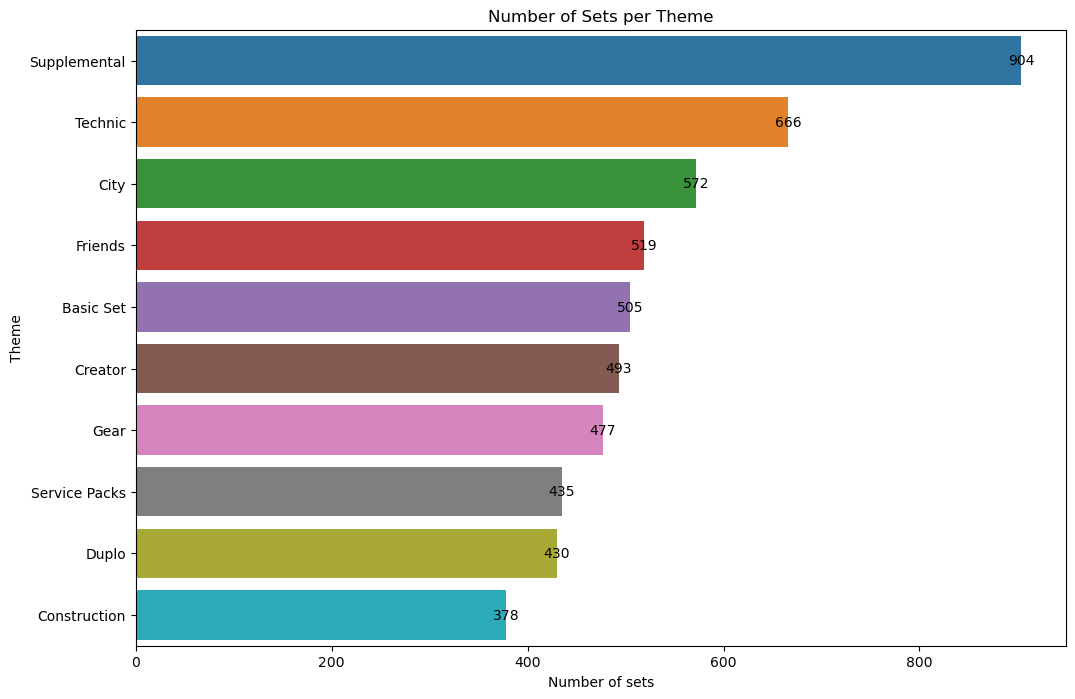

In [6]:
visualize_num_sets_per_theme(df_num_sets_per_theme)

##### Analysis: The analysis shows that Supplemental (904 sets) is the most extensive theme, indicating strong demand for additional parts. Technic (666 sets) and City (572 sets) follow, reflecting their popularity among consumers seeking complex builds and urban-themed scenarios. This data highlights key areas for focused marketing and product development.

#### - Identify the top 10 sets with the most parts to understand the most complex and detailed sets.

In [7]:
df_top_sets_with_most_parts = query_to_dataframe(connection, queries['top_sets_with_most_parts'])
df_top_sets_with_most_parts

,name,num_parts
0,Taj Mahal,5922
1,Star Wars / M&M Mosaic - Promo Set,5461
2,Window Exploration Bag,5200
3,Millennium Falcon - UCS,5195
4,Firehouse Headquarters,4640
5,Personalised Mosaic Portrait,4501
6,Tower Bridge,4295
7,Big Ben,4166
8,The Disney Castle,4060
9,Death Star,4023


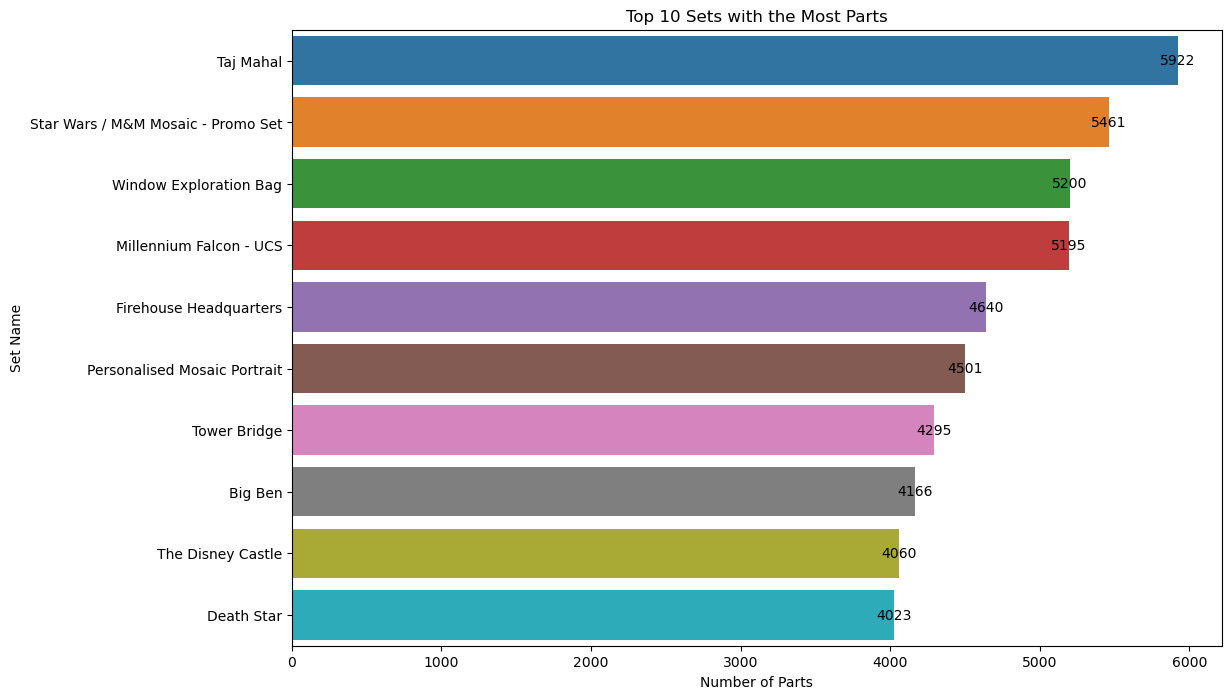

In [8]:
visualize_top_sets_with_most_parts(df_top_sets_with_most_parts)


##### Analysis:  The Taj Mahal leads with 5922 parts, followed by the Star Wars / M&M Mosaic (5461 parts) and Window Exploration Bag (5200 parts), showcasing the most complex and premium sets. These high-piece sets cater to advanced builders and are ideal for targeted marketing campaigns and strategic pricing, emphasizing their intricacy and value.

#### - Themes with the Most Parts: Determine the themes with the highest total number of parts to identify the themes with the most complex sets.

In [9]:
df_themes_with_most_parts = query_to_dataframe(connection, queries['themes_with_most_parts'])
df_themes_with_most_parts

,Theme,Total amount of parts for the theme
0,Basic Set,199262
1,Star Wars Episode 4/5/6,166978
2,Construction,99943
3,Creator,90793
4,Technic,88527
5,Sculptures,78963
6,Traffic,77685
7,Ninjago,74767
8,Friends,69814
9,Star Wars,68111


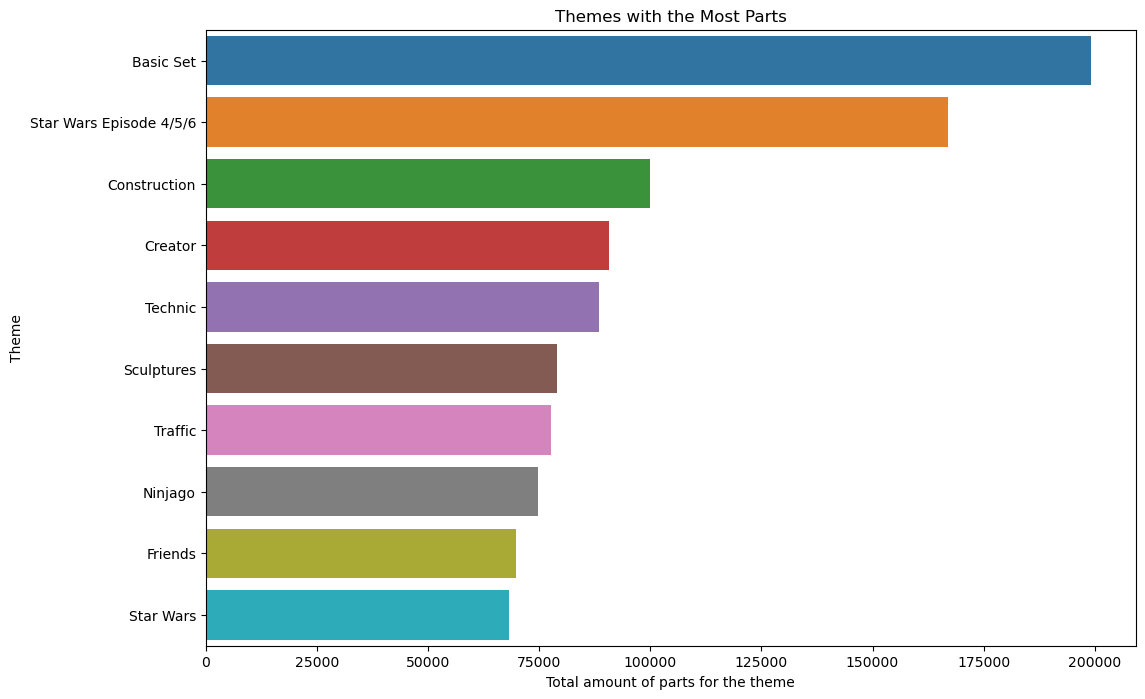

In [10]:
visualize_themes_with_most_parts(df_themes_with_most_parts)

##### Analysis: Basic Set leads with 199,262 parts, followed by Star Wars Episode 4/5/6 (166,978 parts) and Construction (99,943 parts). These themes dominate LEGO's total parts inventory, highlighting their complexity and significant resource allocation, crucial for managing product lines and investment strategies.

#### - Quantity of Pieces in the Oldest Sets Analyze the number of pieces in the oldest sets to understand the complexity of the earliest LEGO sets.

In [11]:
df_quantity_of_pieces_in_oldest_sets = query_to_dataframe(connection, queries['quantity_of_pieces_in_oldest_sets'])
df_quantity_of_pieces_in_oldest_sets

,name,year,num_parts
0,Automatic Binding Bricks Small Brick Set (Lego...,1950,24
1,Individual 2 x 4 Bricks,1950,10
2,Individual 2 x 2 Bricks,1950,9
3,Individual 1 x 2 x 2 Window (without glass),1950,7
4,Individual 1 x 2 x 3 Window (without glass),1950,7
5,Individual 1 x 2 x 4 Door (without glass),1950,7
6,Individual 1 x 4 x 2 Window (without glass),1950,7


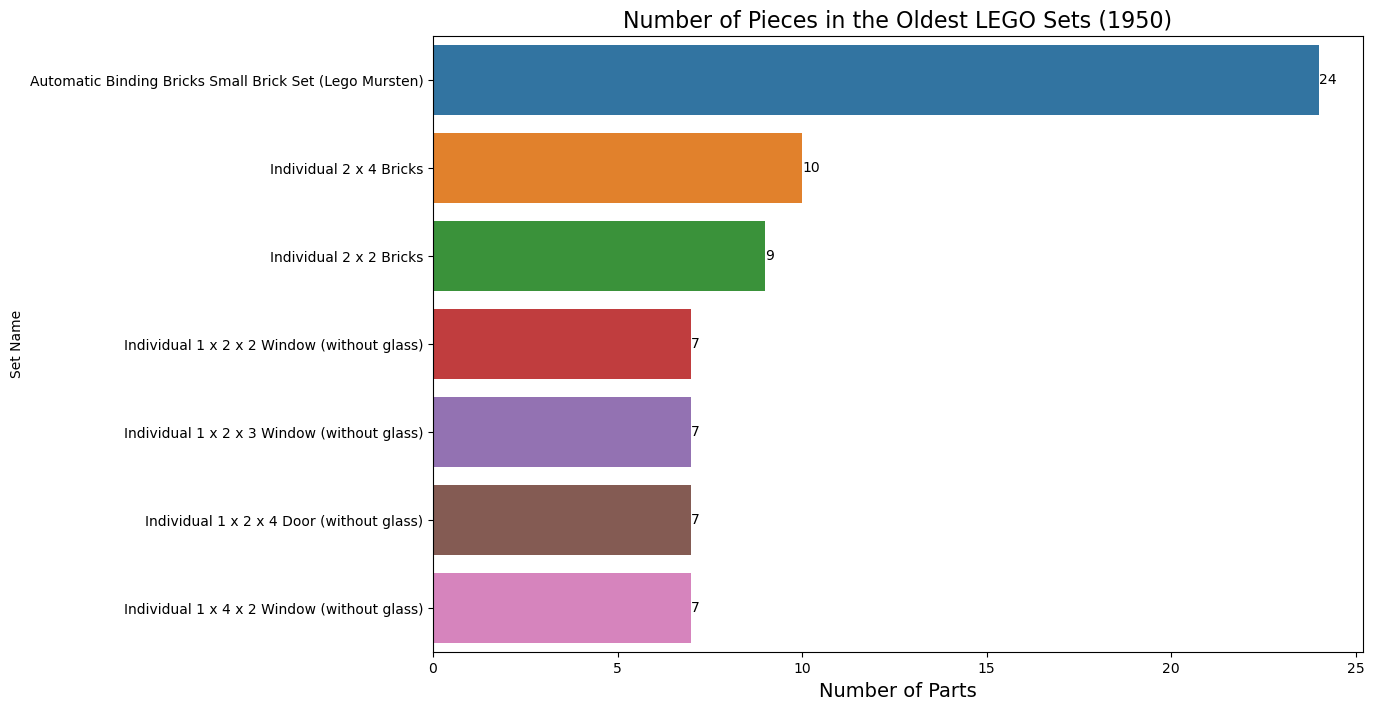

In [12]:
visualize_oldest_sets(connection, queries)


##### Analysis: The oldest sets, like the Automatic Binding Bricks Small Brick Set from 1950 with 24 pieces, illustrate the humble beginnings of LEGO set design. These early sets, with few parts, provide valuable insights into the evolution of LEGO products and are ideal for nostalgic marketing and heritage storytelling.

#### - Changes in the Quantity of Pieces in LEGO Sets from 1950 until 2017 
##### Hypothesis: The average number of pieces in LEGO sets has increased over time.

In [13]:
df_changes_in_quantity_of_pieces = query_to_dataframe(connection, queries['changes_in_quantity_of_pieces'])
df_changes_in_quantity_of_pieces

,year,avg_num_parts
0,1950,10
1,1953,16
2,1954,12
3,1955,37
4,1956,19
...,...,...
61,2013,183
62,2014,172
63,2015,208
64,2016,264


/home/danicoco/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/danicoco/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


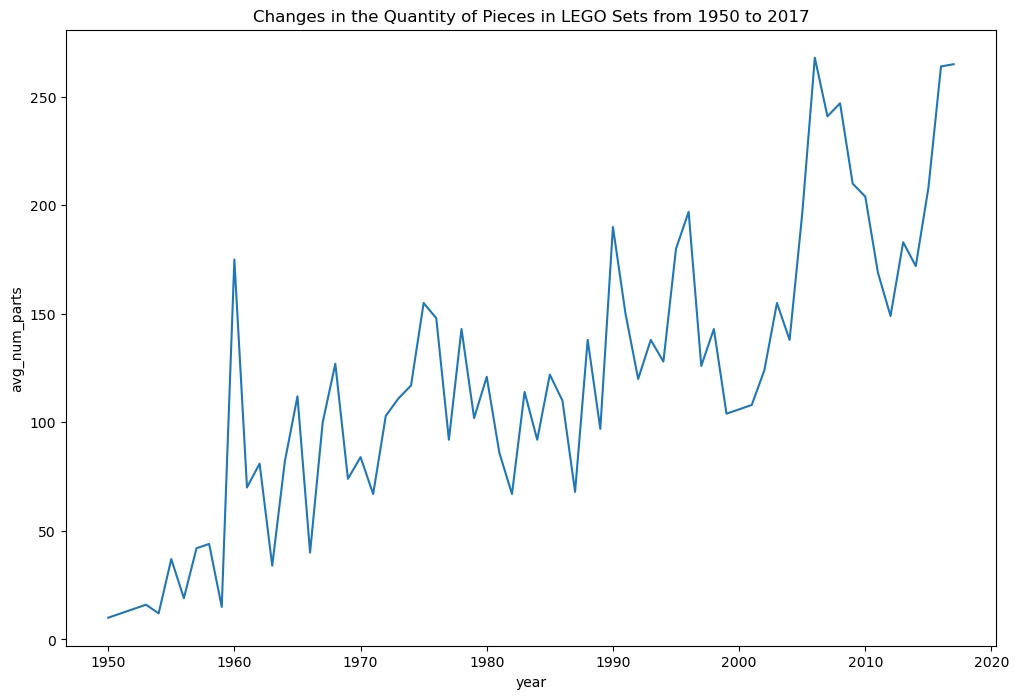

In [14]:
visualize_changes_in_quantity_of_pieces(df_changes_in_quantity_of_pieces)

##### Analysis: The average number of pieces in LEGO sets has significantly increased from 10 pieces in 1950 to 265 pieces in 2017, indicating a trend towards more complex and intricate designs. This trend reflects evolving consumer preferences and can guide future product development and strategic planning to meet the demand for more detailed sets.

#### - Variation in Number of Parts Over Time
##### Hypothesis: The variation in the number of parts in sets has increased over time, indicating a broader range of set complexities.

In [15]:
df_year_variation = query_to_dataframe(connection, queries['variation_num_part_over_year'])
df_year_variation

,year,part_range
0,1950,17
1,1953,47
2,1954,50
3,1955,200
4,1956,96
...,...,...
61,2013,2988
62,2014,3294
63,2015,2995
64,2016,4640


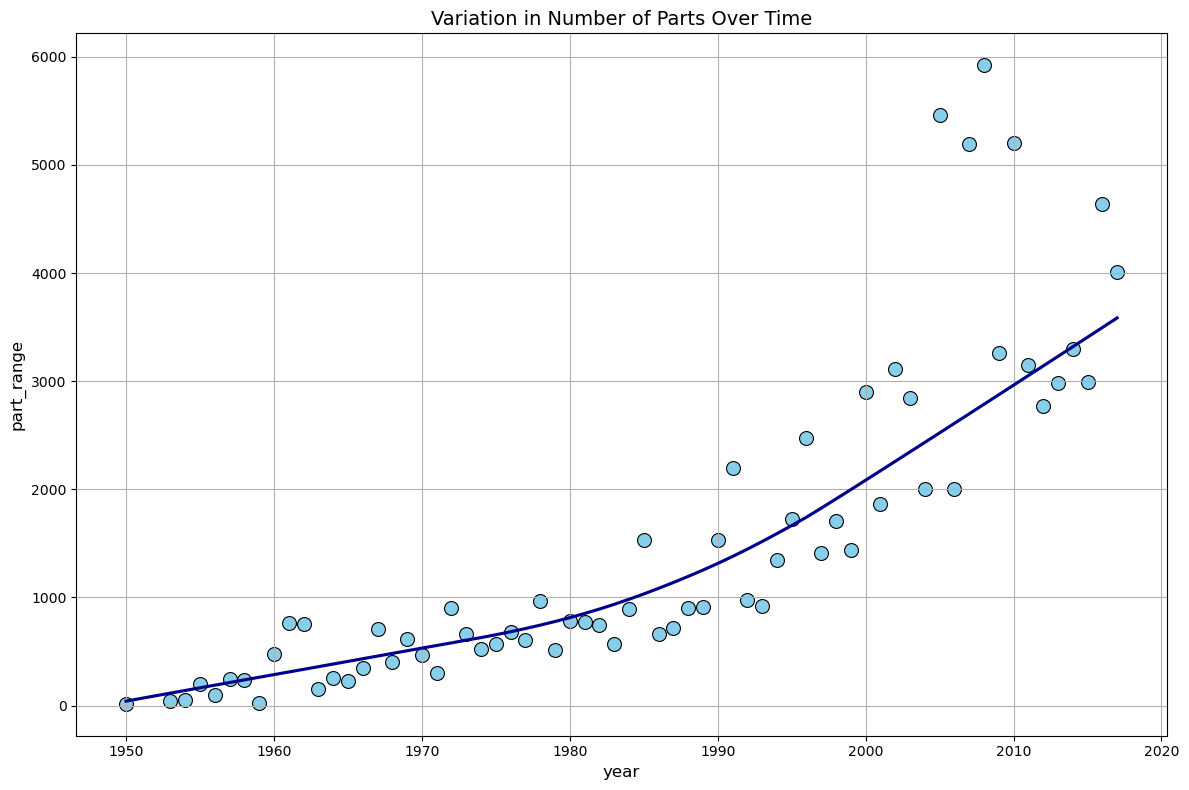

In [16]:
visualize_year_variation(connection, queries)

#### Analysis: Overall, the graph illustrates a clear evolution in the LEGO product line, starting with relatively uniform sets and progressing towards a wide variety of sets with vastly different parts counts. This diversification likely reflects LEGO's adaptation to changing consumer preferences and the desire to appeal to a broader audience.

#### - Most Common Color in Sets
##### Hypothesis: Certain colors are more commonly used in LEGO sets, reflecting popular design choices.

In [17]:
most_common_color_in_sets = query_to_dataframe(connection, queries['most_common_color_in_sets'])
most_common_color_in_sets

,Color,count
0,Black,115176
1,White,66549
2,Light Bluish Gray,55317
3,Red,50217
4,Dark Bluish Gray,43913
5,Yellow,38837
6,Blue,29857
7,Light Gray,25339
8,Reddish Brown,14168
9,Tan,13681


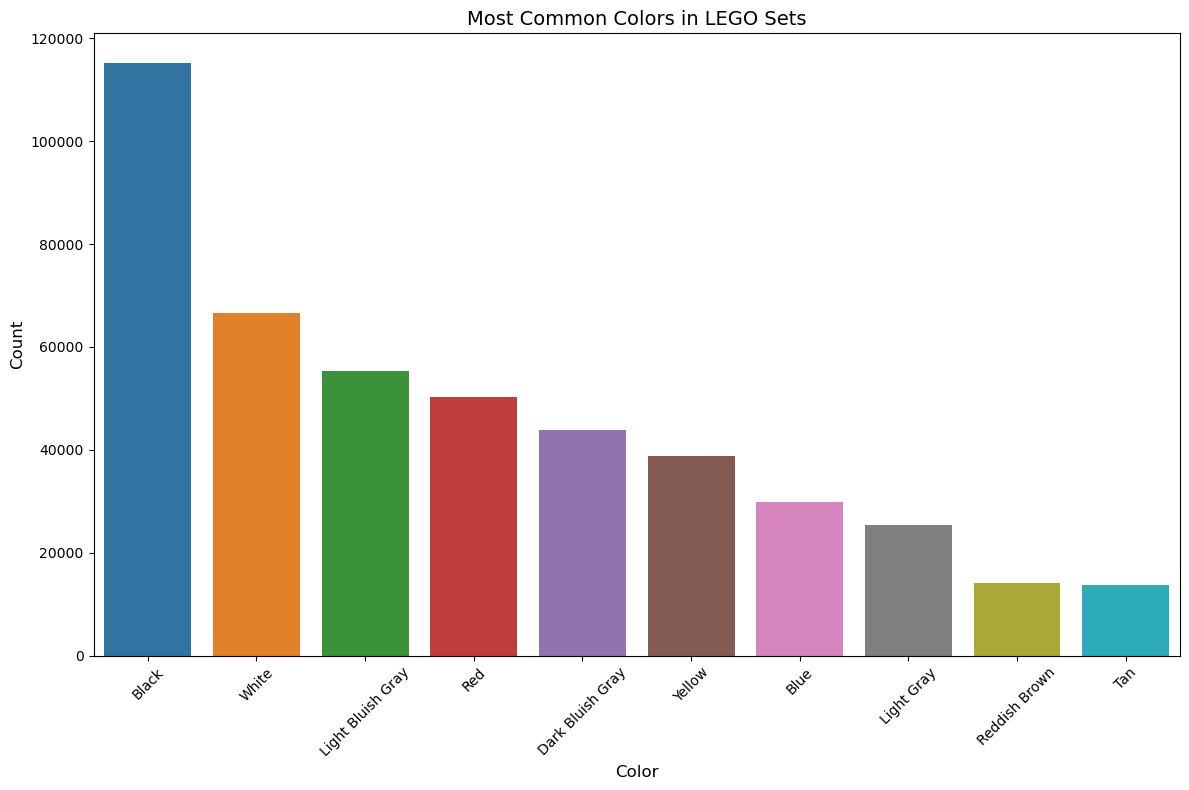

In [18]:
visualize_most_common_colors(connection, queries)

##### Analysis: The bar chart displays the 10 most common LEGO colors, with black being the most frequent and tan the least. White and light bluish gray are also used very frequently. The color distribution suggests a preference for basic and neutral colors in LEGO sets.